-----------------------------------------------------------------------------------------------
# Pridiction of Telstra Network Disruptions
###  Ali Mohammadi (mohammadi.aliakbar@gmail.com)                                         
-----------------------------------------------------------------------------------------------
In their [first recruiting competition](https://www.kaggle.com/c/telstra-recruiting-network), Telstra is challenging Kagglers to predict the severity of service disruptions on their network. Using a dataset of features from their service logs, you're tasked with predicting if a disruption is a momentary glitch or a total interruption of connectivity. <img style="float: right;" src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4726/media/telstra_300.png">
Telstra is on a journey to enhance the customer experience - ensuring everyone in the company is putting customers first. In terms of its expansive network, this means continuously advancing how it predicts the scope and timing of service disruptions. Telstra wants to see how you would help it drive customer advocacy by developing a more advanced predictive model for service disruptions and to help it better serve its customers.
This challenge was crafted as a simulation of the type of problem you might tackle as a member of the team at Telstra.
## Data
The dataset is in a relational format, split among mutliple files. The following step-by-step procedure shows data sets and our method toward prediction in detail.
### Event Type Data
|       Data Fields       | Definition |
|-------------------------|------------|
|ID                   | identifies a unique location-time point|
|EventType                | type of event that occured at that ID (can be multiple events per ID)|
### Log Feature Data
|       Data Fields       | Definition |
|-------------------------|------------|
|ID                   | identifies a unique location-time point|
|Log_Feature               | type of feature logged for that ID|
|Volume              | number of times the feature was logged for that ID|
### Resource Type Data
|       Data Fields       | Definition |
|-------------------------|------------|
|ID                   | identifies a unique location-time point|
|Resource_Type              | type of resource assocaited with that ID|
### Severity Type Data
|       Data Fields       | Definition |
|-------------------------|------------|
|ID                   | identifies a unique location-time point|
|Severity_Type                | type of severity level logged for that ID|
### Training Data
|       Data Fields       | Definition |
|-------------------------|------------|
|ID                   | identifies a unique location-time point|
|Location               | identifier of location|
|Fault_Severity               | categorical. 0: no fault, 1: a few faults, 2: many faults|

## Steps toward prediction
### Step 1: Importing datasets and modules

In [1]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
import re
import numpy as np
warnings.filterwarnings("ignore")
%matplotlib inline

train = pd.read_csv('D:/My Completed Downloads/Telestra/train.csv')
test = pd.read_csv('D:/My Completed Downloads/Telestra/test.csv')
event_type = pd.read_csv('D:/My Completed Downloads/Telestra/event_type.csv')
log_feature = pd.read_csv('D:/My Completed Downloads/Telestra/log_feature.csv')
resource_type = pd.read_csv('D:/My Completed Downloads/Telestra/resource_type.csv')
severity_type = pd.read_csv('D:/My Completed Downloads/Telestra/severity_type.csv')
sample_submission = pd.read_csv('D:/My Completed Downloads/Telestra/sample_submission.csv')
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


The goal of the problem is to predict Telstra network's fault severity at a time at a particular location based on the log data available. Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the "id" column, which is the key "id" used in other data files. 
Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many). “fault_severity” is a measurement of actual reported faults from users of the network and is the target variable (in train.csv).

### Step 2: Data Preprocessing

In [2]:
num_train_data = train.shape[0]
enc = preprocessing.OneHotEncoder(sparse=False)
Y = enc.fit_transform(train[['fault_severity']].as_matrix()) # Y contains targets

train_test = train.drop(['fault_severity'],axis=1)
train_test = train_test.append(test,ignore_index=True)
train_test['location'] = train_test.location.map(lambda x: re.findall(r'\d+',x)[0])

data = event_type.merge(resource_type, on = 'id', how = 'inner')
data = data.merge(severity_type, on = 'id', how = 'inner')
data = data.merge(log_feature, on = 'id', how = 'inner')
data['severity_type'] = data.severity_type.map(lambda x: re.findall(r'\d+',x)[0])
data['log_feature'] = data.log_feature.map(lambda x: re.findall(r'\d+',x)[0])
data['event_type'] = data.event_type.map(lambda x: re.findall(r'\d+',x)[0])
data['resource_type'] = data.resource_type.map(lambda x: re.findall(r'\d+',x)[0])

all_data = pd.merge(train_test, data, on='id', how='inner')
all_data.head(10)
#data.head()

,id,location,event_type,resource_type,severity_type,log_feature,volume
0,14121,118,34,2,2,312,19
1,14121,118,34,2,2,232,19
2,14121,118,35,2,2,312,19
3,14121,118,35,2,2,232,19
4,9320,91,34,2,2,315,200
5,9320,91,34,2,2,235,116
6,9320,91,35,2,2,315,200
7,9320,91,35,2,2,235,116
8,14394,152,35,2,2,221,1
9,14394,152,35,2,2,301,1


Different types of features are extracted from log files and other sources: event_type.csv, log_feature.csv, resource_type.csv, severity_type.csv. All above features are categorical except for "volume".
Note: “severity_type” is a feature extracted from the log files (in severity_type.csv). Often this is a severity type of a warning message coming from the log. "severity_type" is categorical. It does not have an ordering. 

### Step 3: Feature Extraction

In [5]:
feature_name = ['location', 'event_type', 'resource_type', 'severity_type', 'log_feature']
enc = preprocessing.OneHotEncoder(n_values=np.array([1127, 55, 11, 6, 387]), sparse=False)
features = all_data['id']
features = pd.concat([features, \
        pd.DataFrame(data=enc.fit_transform(all_data[feature_name].as_matrix()))], axis=1)
features = features.astype(int)
features['vol'] = all_data['volume']
feature_name.append('volume')
features = features.groupby(['id'],sort=False, as_index=False).sum()
features.head() 

,id,0,1,2,3,4,5,6,7,8,...,1577,1578,1579,1580,1581,1582,1583,1584,1585,vol
0,14121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,76
1,9320,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,632
2,14394,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,8218,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,44
4,14804,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,96


Above table shows 1587 exctracted features. We might not need all of them for further progress. We try to estimate the importance of each feature in the next step.

### Step 4: Feature Selection
We use cross-correlation analysis to see how features and targets are correlated. 

In [6]:
features_norm = (features - features.mean()) / (features.max() - features.min())
cross_corr = features_norm[:num_train_data].drop(['id'],axis=1)
cross_corr['Y0'] = Y[:,0]
cross_corr['Y1'] = Y[:,1]
cross_corr['Y2'] = Y[:,2]
cross_corr = cross_corr.corr().fillna(0)
cross_corr = cross_corr[['Y0', 'Y1', 'Y2']].drop(['Y0', 'Y1', 'Y2'])
cross_corr.transpose()

,0,1,2,3,4,5,6,7,8,9,...,1577,1578,1579,1580,1581,1582,1583,1584,1585,vol
Y0,0.0,-0.013146,-0.023841,0.011507,-0.022345,0.008577,-0.015799,-0.004467,0.000210,0.036367,...,-0.017495,-1.762242e-15,-0.015799,-1.762242e-15,-1.762242e-15,-0.020538,0.008577,-1.762242e-15,-1.762242e-15,0.031061
Y1,0.0,0.015727,0.031237,-0.009101,0.028252,-0.006783,0.019976,-0.015486,0.005416,-0.028763,...,-0.002030,-3.890519e-16,-0.006783,-3.890519e-16,-3.890519e-16,-0.008818,-0.006783,-3.890519e-16,-3.890519e-16,-0.102434
Y2,0.0,-0.001892,-0.007398,-0.005159,-0.005438,-0.003845,-0.003845,0.029784,-0.008248,-0.016303,...,0.031020,-4.430143e-16,0.035243,-4.430143e-16,-4.430143e-16,0.045814,-0.003845,-4.430143e-16,-4.430143e-16,0.099820


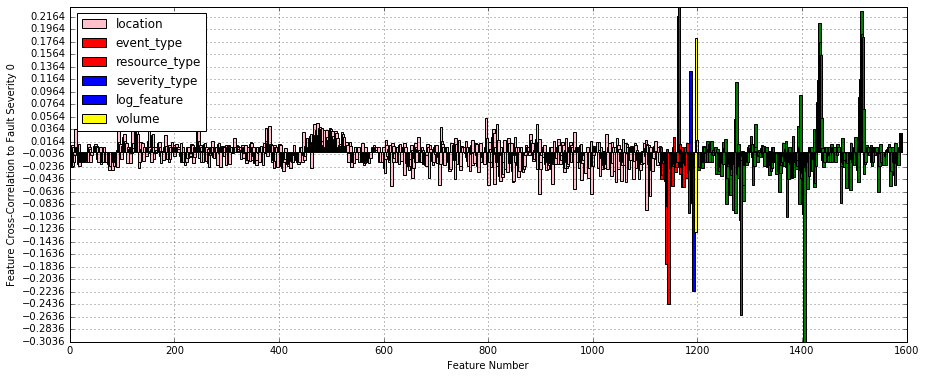

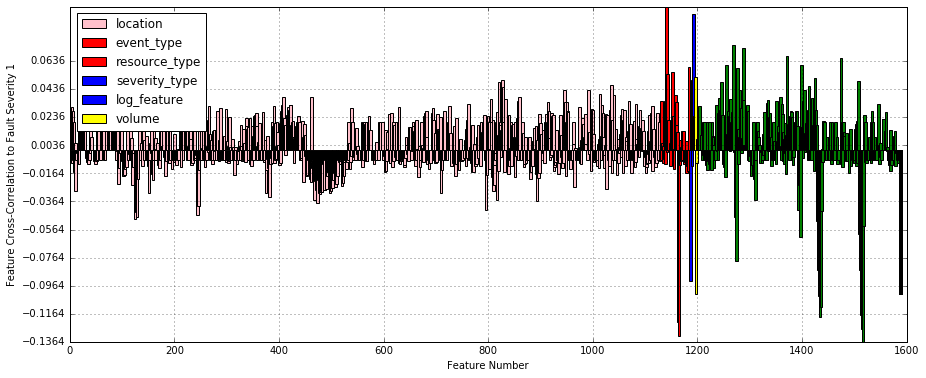

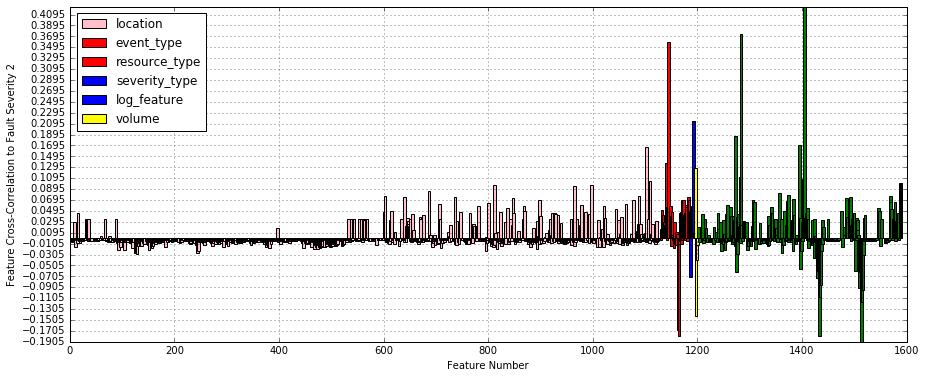

In [58]:
clr = ['pink', 'red', 'blue', 'yellow', 'green', 'black']

for idx_corr in range(3):
    Y_corr = cross_corr.iloc[:,idx_corr]
    plt.figure(figsize=(15,6))
    for idx, n_featuer in enumerate(enc.n_values):
        xx = np.arange(enc.feature_indices_[idx], enc.feature_indices_[idx+1])
        yy = Y_corr[xx]
        plt.bar(xx, yy, width=5, color=clr[idx])
        plt.bar(1586,Y_corr[1586], width, color=clr[idx+1])
        plt.xlabel('Feature Number')
        plt.ylabel('Feature Cross-Correlation to Fault Severity '+str(idx_corr))
        plt.yticks(np.arange(min(yy), max(yy), 0.02))
        plt.grid(which='both', axis='both') 
        plt.legend(feature_name, bbox_to_anchor=(0.17, 1))    

* It is interesting to note that locations labeled as 0 to almost 550 are less correlated to fault sevierity type 2.
* We can select out those features that are most correlated to Fault Sevierities to estimate model. 
* We should choose a threshold on cross-correlations to select out features.

### Step 5: Model Selection and Regularization
A wide class of models were experienced using data for Telestra Network Disrruption Prediction; Generalized Linear Models, Linear and Quadratic Discriminant Analysis, Kernel ridge regression, Support Vector Machines, Nearest Neighbors, Stochastic Gradient Descent, Cross decomposition, Naive Bayes, Decision Trees and Ensemble methods. Amonge Ensemble methods , I choose **Gradient Boosting Classifier** for its beter performance. I used **Grid Search and Cross Validation** to regularized the model. In order to complete feature selection process I decide on **Cross-Correlation Threshold (cct)** in following.

In [30]:
cct = 0.03 # Cross-Correlation Thereshold

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib

for idx in range(3):
    X = features_norm[:num_train_data].drop(['id'],axis=1).as_matrix()
    X = X[:,np.transpose(np.nonzero(np.absolute(cross_corr.iloc[:,idx])>cct))][:,:,0]
    gb = GradientBoostingClassifier()
    clf = GridSearchCV(gb, {'max_depth': [2, 3, 4],\
                            'n_estimators': [100, 150], \
                           'learning_rate': [0.5], \
                           'subsample': [1],\
                           'max_leaf_nodes': [3]}, verbose=1, n_jobs=2, \
                           cv=3, scoring='log_loss')
    clf.fit(X, Y[:,idx])
    joblib.dump(clf, 'D:/My Completed Downloads/Telestra/clfgb'+str(idx)+'.pkl')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:  1.3min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:   55.1s finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:  1.5min finished


### Step 6: Prediction

In [60]:
Y_pred = []
log_loss = []
for idx in range(3):
    clf = joblib.load('D:/My Completed Downloads/Telestra/clfgb'+str(idx)+'.pkl') 
    X_t = features_norm[num_train_data:].drop(['id'],axis=1).as_matrix()
    X_t = X_t[:,np.transpose(np.nonzero(np.absolute(cross_corr.iloc[:,idx])>cct))][:,:,0]
    Y_pred.append(clf.predict_proba(X_t))
    log_loss.append(-clf.best_score_)
    print('Number of features for model ' + str(idx) + ' : ' + str(X_t.shape[1]))
    
print('Model log-loss: ' + str(np.mean(log_loss)))
    

prediction = pd.DataFrame({'id': features[num_train_data:].id, \
                   'predict_0': Y_pred[0][:,1],\
                  'predict_1': Y_pred[1][:,1],\
                  'predict_2': Y_pred[2][:,1]})

prediction.to_csv('D:/My Completed Downloads/Telestra/Telestra_gbclf.csv',index=False)
prediction.head()


Number of features for model 0 : 187
Number of features for model 1 : 129
Number of features for model 2 : 212
Model log-loss: 0.367333249564


,id,predict_0,predict_1,predict_2
7381,11066,0.939775,0.055186,0.004434
7382,18000,0.361105,0.153071,0.750615
7383,16964,0.963316,0.030839,0.003617
7384,4795,0.677731,0.134130,0.012755
7385,3392,0.426650,0.654325,0.250176


## Summary and Conclusions
In this project, I predicted service faults on Australia's largest telecommunications network using data provided in a [kaggle competition](https://www.kaggle.com/c/telstra-recruiting-network). Data are in five datasets including six potential features which five of them are categorical. Therefore, I used One-Hot-Encoder from [Scikit-Learn](http://scikit-learn.org/) to produce a sparse matrix of 1588 binary features including unique labels for each location, event type, resource type, severity type, and log feature. After normalization of data, I did a cross-correlation analysis and computed [Pearson Cross-Correlations between features and targets](https://en.wikipedia.org/wiki/Correlation_and_dependence) to gain idea about the amount of their linear relations. In above simulations, I could select out around 200 features by setting cross-correlation threshold to 0.03. Then, I virtually tried all Scikit-Learn models to decide on the final prediction model. Eventually, I chose [Gradient Boosting Classification](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) for modelling our problem. I also used [Grid Search](http://scikit-learn.org/stable/modules/grid_search.html) to regularize model parameters and cross-validate the models. 

In conclusion, I solved the problem using two strategies; a multi-label classification problem, and three binary classification problem. Here, I presented the later since it achieved better scores. It is noticeable that the best final model [Log-Loss](https://www.kaggle.com/wiki/LogarithmicLoss) is 0.36733 in above simulations. I also compared my results with others in [competition submission webpage](https://www.kaggle.com/c/telstra-recruiting-network/submissions/attach) by submitting files containing predictions of class probabilities for each observation. My best log-loss was 0.57557 which is quite good comparing with the best log-loss gained in the competition (0.39546). My best position was 558 among 974 competitors. It is a considerable result since I spent less than a week to solve the problem and prepare the report.


## References
1. [Telstra Kaggle Competition](https://www.kaggle.com/c/telstra-recruiting-network)
2. [Scikit-Learn; Machine Learning in Python](http://scikit-learn.org/)
3. [Pandas](http://pandas.pydata.org/)
4. [Matplot](http://matplotlib.org/)

-----------------------------------------------------------------------------------------------

>> # Ali Mohammadi
## Tel: +61431371072
>> ## Email: mohammadi.aliakbar@gmail.com 
